# Heart Failure Prediction

### Machine Learning Modeling

This notebook focuses on the following  modeling steps:
* Data preparation:
    * Split into training, validation and testing data sets.
* Modeling and Evaluation:
    * Training models: Logistic Regression, Decision Tree, Random Forest, Gradient Boosting (XGBoost).
    * Evaluation on trained models using confusion matrix, AUC scoring.
    * Identify important features.
* Hyperparameter-tuning on best model.
* Save the final model
    * Test final model on unseen data (test data set).
    * Train and test final model on training + validation data sets, evaluate on test data set.
    * Save final model and final `DictVectorizer`. 

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import os
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction import DictVectorizer


#### 1. Load pre-processed data set

In [34]:
df = pd.read_csv("../data/heart_processed.csv")
df.head()

,Age,RestingBP,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,FastingBS_1,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up,Cholesterol_Level_Borderline High,Cholesterol_Level_High,Cholesterol_Level_Very High
0,40,140,172,0.0,0,True,True,False,False,False,True,False,False,False,True,False,True,False
1,49,160,156,1.0,1,False,False,True,False,False,True,False,False,True,False,False,False,False
2,37,130,98,0.0,0,True,True,False,False,False,False,True,False,False,True,False,True,False
3,48,138,108,1.5,1,False,False,False,False,False,True,False,True,True,False,True,False,False
4,54,150,122,0.0,0,True,False,True,False,False,True,False,False,False,True,False,False,False


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917 entries, 0 to 916
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                917 non-null    int64  
 1   RestingBP                          917 non-null    int64  
 2   MaxHR                              917 non-null    int64  
 3   Oldpeak                            917 non-null    float64
 4   HeartDisease                       917 non-null    int64  
 5   Sex_M                              917 non-null    bool   
 6   ChestPainType_ATA                  917 non-null    bool   
 7   ChestPainType_NAP                  917 non-null    bool   
 8   ChestPainType_TA                   917 non-null    bool   
 9   FastingBS_1                        917 non-null    bool   
 10  RestingECG_Normal                  917 non-null    bool   
 11  RestingECG_ST                      917 non-null    bool   

#### 2. Data Preparation

Split dataset into training, validation & test sets.

In [36]:
y = df['HeartDisease']
X = df.drop(columns=['HeartDisease'])

In [37]:
# Split the data into training validation and test sets (60%, 20%, 20%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, shuffle=True, stratify=y_train)

In [38]:
# Check split sizes

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(549, 17) (184, 17) (184, 17)
(549,) (184,) (184,)


#### 3. Model Training & Evaluation

* Train 5 candidate models: `LogisticRegression`, `DecisionTreeClassifier`, `RandomForestClassifier`, `GradientBoostingClassifier` & `SupportVectorMachine`.
    * To ensure the tree models are compared on a similar level, the hyperparameter `max_depth` is set to be the same instead of using their default values. (except for `LogisticRegression`  and `SupportVectorMachine` which doesn't have such hyperparameter)
    * For reproducibility, random states are set 
* Evaluate the candidate models on training and validation dataset.
    * Compute the False Positive Rates, True Positive Rates for each model-dataset pair using Confusion Matrix.
    * Compute the AUC scores for each model-dataset pair. 

In [39]:
random_state = 42
lr = LogisticRegression(solver='liblinear',  random_state=random_state)
dt = DecisionTreeClassifier( max_depth=3, random_state=random_state)
rf = RandomForestClassifier( max_depth=3, random_state=random_state)
gbm = GradientBoostingClassifier( max_depth=3, random_state=random_state)
svm = SVC(kernel='linear', C=1.0, random_state=random_state, probability=True)


models = {"LogisticRegression": lr, 
          "DecisionTreeClassifier": dt,
          "RandomForestClassifier": rf,
         "GradientBoostingClassifier": gbm,
         "SupportVectorMachine": svm}

In [40]:
def train_model(model, X_train, y_train, X_val):
    '''
    train model and predict on training and validation sets
    '''
    model.fit(X_train, y_train)
    train_pred = model.predict_proba(X_train)[:,1]
    val_pred = model.predict_proba(X_val)[:,1]
    return model, train_pred, val_pred

In [41]:
results = {}
trained_models = {}
for k, m in models.items():
    trained_model, train_pred, val_pred = train_model(m, X_train, y_train, X_val)
    # store trained model
    trained_models[k] = trained_model
    
    # compute false positive rate, true positive rate on training and validation set
    fpr_train, tpr_train, _ = roc_curve(y_train, train_pred)
    fpr_val, tpr_val, _ = roc_curve(y_val, val_pred)
    
    # compute auc scoring on training and validation set
    AUC_train = roc_auc_score(y_train, train_pred) 
    AUC_val = roc_auc_score(y_val, val_pred)

    # save evaluation results
    results[k] = (fpr_train, tpr_train, fpr_val, tpr_val, AUC_train, AUC_val)

##### Confusion Matrix

Plot the confusion matrix for each candidate model used to evaluate the validation dataset..

In [42]:
def confusion_matrix(subtitle, model):
    fig, ax = plt.subplots(figsize=(3,3))
    fig.suptitle(f"Confusion Matrix for {subtitle}")
    cmd = ConfusionMatrixDisplay.from_estimator(
        model, X_val, y_val, display_labels=['No', 'Yes'], ax=ax)
    cmd.ax_.set_xlabel("Predicted Heart Disease")
    cmd.ax_.set_ylabel("Actual Heart Disease")
    plt.show()

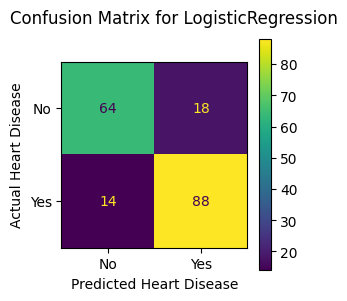

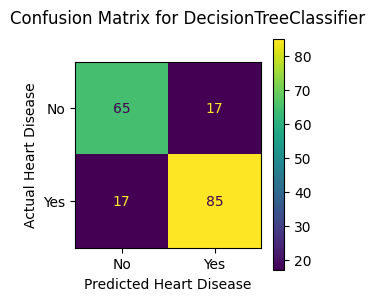

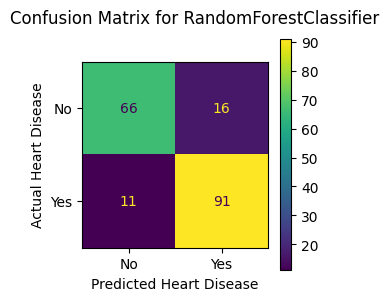

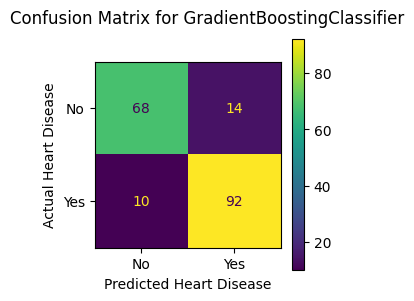

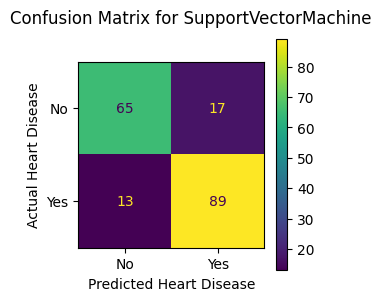

In [43]:
for k,v in trained_models.items():
    confusion_matrix(k, v)

When examining the confusion matrix, note the following:

The diagonal elements represent correct predictions: true negatives (top left) and true positives (bottom right).
The off-diagonal elements represent prediction errors: false positives (top right) and false negatives (bottom left).
The emphasis should be on the off-diagonal elements, particularly on reducing false negatives.

It is preferable to predict a potential heart disease case (false positive) and conduct a thorough medical examination, even if it turns out to be a false alarm. It is much more critical to avoid predicting a healthy status for someone who actually has heart disease (false negative), as this could prevent early intervention and increase the risk of fatal outcomes.

In our case the `GradientBoostingClassifier` predicted the lowest false negatives, followed by `RandomForestClassifier`

##### ROC AUC Scores
Compare ROC AUC scores between candidate models. 

The ROC AUC score is a performance measurement for classification problems at various threshold settings. ROC stands for Receiver Operating Characteristic, and AUC stands for Area Under the Curve.

ROC Curve:

The ROC curve is a graphical representation of a classifier's performance.
It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at different threshold levels.

AUC (Area Under the Curve):

The AUC measures the entire two-dimensional area underneath the entire ROC curve.
The AUC value ranges from 0 to 1. A higher AUC indicates a better performing model.

Relevance:

The ROC AUC score provides an aggregate measure of a model's performance across all classification thresholds.

It is particularly useful for evaluating models when the classes are imbalanced.
A higher ROC AUC score indicates that the model is better at distinguishing between positive and negative classes.

In summary, the ROC AUC score helps in understanding the trade-off between sensitivity (True Positive Rate) and specificity (False Positive Rate) for different thresholds, making it a valuable metric for evaluating the performance of classification models.

In [44]:
# Compile the evaluation results
df_eval = pd.DataFrame(results, index=['train_fpr', 'train_tpr',  
                                       'val_fpr', 'val_tpr', 
                                       'train_auc_score', 'val_auc_score'])
df_eval = df_eval.T
df_eval.reset_index(inplace=True)
df_eval.rename(columns={'index':'model'}, inplace=True)
df_eval.head()

,model,train_fpr,train_tpr,val_fpr,val_tpr,train_auc_score,val_auc_score
0,LogisticRegression,"[0.0, 0.0, 0.0, 0.0040650406504065045, 0.00406...","[0.0, 0.0033003300330033004, 0.191419141914191...","[0.0, 0.0, 0.0, 0.012195121951219513, 0.012195...","[0.0, 0.00980392156862745, 0.08823529411764706...",0.933671,0.902917
1,DecisionTreeClassifier,"[0.0, 0.0, 0.04065040650406504, 0.044715447154...","[0.0, 0.006600660066006601, 0.6171617161716172...","[0.0, 0.024390243902439025, 0.0975609756097561...","[0.0, 0.0, 0.5980392156862745, 0.6176470588235...",0.909456,0.854316
2,RandomForestClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00406504...","[0.0, 0.0033003300330033004, 0.009900990099009...","[0.0, 0.0, 0.0, 0.012195121951219513, 0.012195...","[0.0, 0.00980392156862745, 0.10784313725490197...",0.936898,0.905548
3,GradientBoostingClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0033003300330033004, 0.108910891089108...","[0.0, 0.0, 0.0, 0.012195121951219513, 0.012195...","[0.0, 0.00980392156862745, 0.04901960784313725...",0.991575,0.909374
4,SupportVectorMachine,"[0.0, 0.0, 0.0, 0.0040650406504065045, 0.00406...","[0.0, 0.0033003300330033004, 0.125412541254125...","[0.0, 0.0, 0.0, 0.012195121951219513, 0.012195...","[0.0, 0.00980392156862745, 0.08823529411764706...",0.931927,0.906265


Plot the ROC AUC plots of each model by:
* training ROC curve
* validation ROC curve

In [45]:
def plot_roc_curve(data, title, fpr, tpr, score): 
    plt.figure(figsize=(4,4))
    _ = data.apply(lambda row: sns.lineplot(x=row[fpr], \
                                               y=row[tpr], \
                                               label=f"{row['model']}={row[score]:.4f}", \
                                               errorbar=None), axis=1)
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(linestyle='-', color='0.8')
    plt.show()

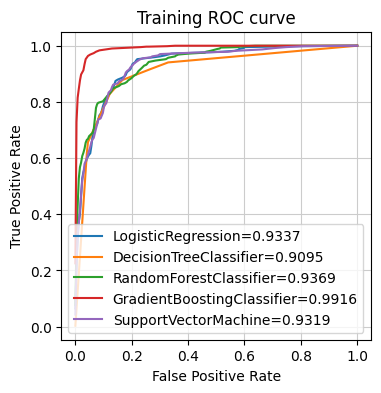

In [46]:
plot_roc_curve(df_eval, "Training ROC curve", 'train_fpr', 'train_tpr', 'train_auc_score')

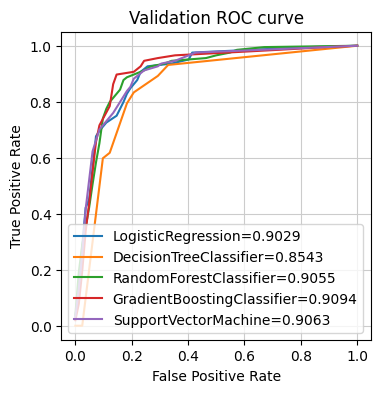

In [47]:
plot_roc_curve(df_eval, "Validation ROC curve", 'val_fpr', 'val_tpr', 'val_auc_score')

##### Key Observations

##### Training Performance:

GradientBoostingClassifier dominates with an AUC of 0.9916, near-perfect performance, suggesting excellent training fit.

Other models (Logistic Regression, Decision Tree, Random Forest, SVM) show strong but lower AUCs (0.9095–0.9369).

##### Validation Performance:

All models exhibit lower AUCs compared to training, indicating potential overfitting.

GradientBoostingClassifier still leads (AUC=0.9094), but its performance drops significantly (Δ ~0.08), signaling overfitting.

RandomForest (0.9055) and SVM (0.9063) show smaller gaps between training and validation, suggesting better generalization.

DecisionTreeClassifier performs worst (AUC=0.8543), likely due to high variance.


#### 4. Hyper Parameter Tuning

We need to select couple of models based on performance so far ( ROC curves and confusion matrices)

 1. Gradient Boosting Classifier  
   - Strengths:  
     - Highest validation AUC (0.9094) and best overall performance.  
     - Confusion matrix metrics (e.g., F1-score ≈ 88.5%) indicate strong predictive power.  
   - Weakness:  
     - Significant overfitting (Training AUC=0.9916 vs. Validation AUC=0.9094).  
   - Tuning Focus:  
     - Regularization: Reduce `max_depth`, increase `min_samples_split`, or lower `learning_rate`.  
     - Complexity Control: Adjust `n_estimators` or `subsample` to prevent overfitting.  
 2. Random Forest Classifier  
   - Strengths:  
     - High validation AUC (0.9055) with minimal overfitting (Δ=0.0314).  
     - Balanced confusion matrix (e.g., F1-score ≈ 87.1%).  
   - Tuning Focus:  
     - Tree Parameters: Optimize `n_estimators`, `max_features`, or `min_samples_leaf`.  
     - Generalization: Experiment with `bootstrap` or `class_weight` for class imbalance.  
 3. Support Vector Machine (SVM)  
   - Strengths:  
     - Competitive validation AUC (0.9063).  
     - Confusion matrix suggests decent precision/recall balance.  
   - Tuning Focus:  
     - Kernel Adjustments: Test `rbf` or `poly` kernels instead of default `linear`.  
     - Regularization: Optimize `C` (penalty) and `gamma` (kernel influence).  

 Models to Avoid

 ❌ Decision Tree Classifier  
   - Weaknesses:  
     - Lowest validation AUC (0.8543) and high variance (F1≈83.3%).  
     - Prone to overfitting (e.g., Training AUC=0.9095 vs. Validation AUC=0.8543).  

 ❌ Logistic Regression  
   - Weaknesses:  
     - Stable but plateaued performance (Validation AUC=0.9029).  
     - Limited gains from hyperparameter tuning unless paired with feature engineering.  


- Gradient Boosting offers the highest potential but requires strict regularization.  
- Random Forest is a robust, generalizable choice for reliable performance.  
- SVM could yield improvements with kernel tuning but has a steeper learning curve.  

Prioritizing Gradient Boosting and Random Forest for tuning, given their strong validation performance and room for improvement.

##### Grid Search on Gradient Boosting Classifier

In [50]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Gradient Boosting Classifier
gbm = GradientBoostingClassifier(random_state=random_state)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_gbc = grid_search.best_params_
print(f'Best parameters: {best_params_gbc}')


Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}


##### Grid Search on Random forest classifier

In [52]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_rfc = grid_search.best_params_
print(f'Best parameters: {best_params_rfc}')

Best parameters: {'bootstrap': False, 'max_depth': 4, 'min_samples_leaf': 4, 'n_estimators': 200}


#### 5. Fit & Evaluate Fine Tuned models

For the finetuned models,
* Train on training data.
* Plot confusion matrix after evaluated on validation dataset.
* Plot ROC curve.

In [53]:
def plot_roc_curve_ft(model, X_train, X_val, title): 
    # Compute false positive rate, true positive rate for training and validation predictions
    train_pred = model.predict_proba(X_train)[:,1]
    val_pred = model.predict_proba(X_val)[:,1]
    
    fpr_train, tpr_train, _ = roc_curve(y_train, train_pred)
    fpr_val, tpr_val, _ = roc_curve(y_val, val_pred)

    # AUC scoring on training and validation dataset
    AUC_train = roc_auc_score(y_train, train_pred) 
    AUC_val = roc_auc_score(y_val, val_pred)

    plt.figure(figsize=(4,4))
    sns.lineplot(x=fpr_train, y=tpr_train, label=f"Training AUC score={AUC_train:.4f}", errorbar=None)
    sns.lineplot(x=fpr_val, y=tpr_val, label=f"Validation AUC score={AUC_val:.4f}", errorbar=None)
    plt.title(f"{title} ROC curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(linestyle='-', color='0.8')
    plt.show()

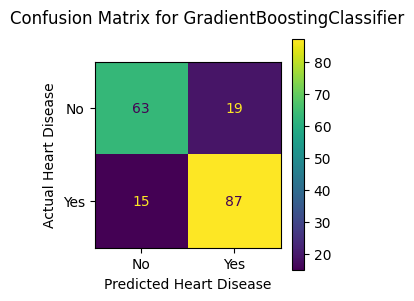

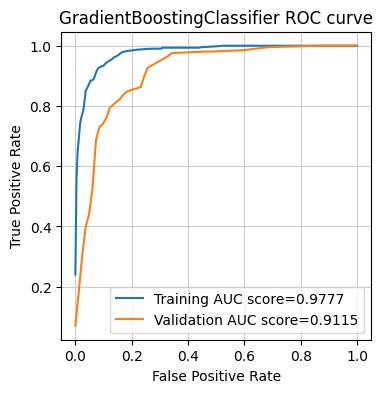

In [54]:
gbm_tuned = GradientBoostingClassifier(**best_params_gbc, random_state=random_state)
gbm_tuned.fit(X_train, y_train)
confusion_matrix("GradientBoostingClassifier", gbm_tuned)
plot_roc_curve_ft(gbm_tuned, X_train, X_val, "GradientBoostingClassifier")



In [55]:
val_predictions = gbm_tuned.predict(X_val)

accuracy = accuracy_score(y_val, val_predictions) * 100
precision = precision_score(y_val, val_predictions) * 100
recall = recall_score(y_val, val_predictions) * 100
f1 = f1_score(y_val, val_predictions) * 100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")

Accuracy: 81.52%
Precision: 82.08%
Recall: 85.29%
F1 Score: 83.65%


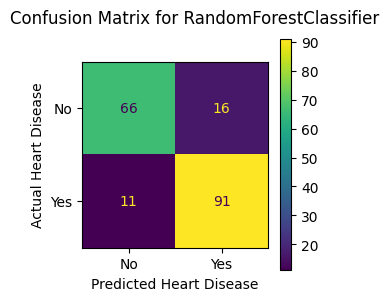

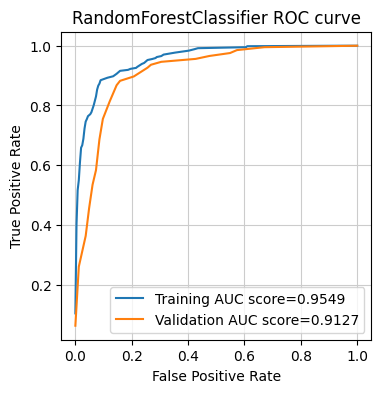

In [56]:
rf_tuned = RandomForestClassifier(**best_params_rfc, random_state=random_state)
rf_tuned.fit(X_train, y_train)
confusion_matrix("RandomForestClassifier", rf_tuned)
plot_roc_curve_ft(rf_tuned, X_train, X_val, "RandomForestClassifier")

In [57]:
val_predictions = rf_tuned.predict(X_val)

accuracy = accuracy_score(y_val, val_predictions) * 100
precision = precision_score(y_val, val_predictions) * 100
recall = recall_score(y_val, val_predictions) * 100
f1 = f1_score(y_val, val_predictions) * 100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")

Accuracy: 85.33%
Precision: 85.05%
Recall: 89.22%
F1 Score: 87.08%


| Model                   | Validation AUC | Precision (Yes) | Recall (Yes) | Accuracy  |
|-------------------------|----------------|------------------|--------------|-----------|
| **Random Forest**       | **0.9127**     | **85.05%**       | **89.22%**   | **85.33%**|
| Gradient Boosting       | 0.9115         | 82.08%           | 85.29%       | 83.65%    |


**Random Forest Classifier** is the better model for deployment because:  
- It maximizes **recall** for heart disease detection (critical for patient safety).  
- Balances precision and accuracy effectively.  
- Generalizes better to unseen data (higher validation AUC).  
 

##### 6. Test the final model

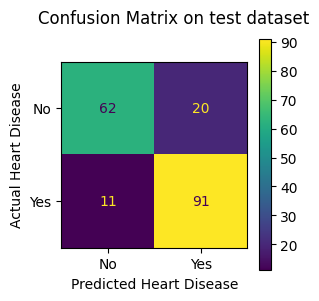

In [58]:
fig, ax = plt.subplots(figsize=(3,3))
fig.suptitle(f"Confusion Matrix on test dataset")
cmd = ConfusionMatrixDisplay.from_estimator(
    rf_tuned, X_test, y_test, display_labels=['No', 'Yes'], ax=ax)
cmd.ax_.set_xlabel("Predicted Heart Disease")
cmd.ax_.set_ylabel("Actual Heart Disease")
plt.show()

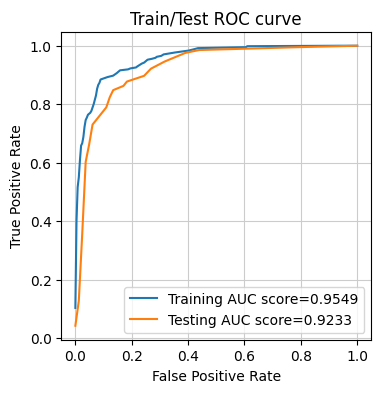

In [59]:
# Compute false positive rate, true positive rate for training and validation predictions
train_pred = rf_tuned.predict_proba(X_train)[:,1]
test_pred = rf_tuned.predict_proba(X_test)[:,1]

fpr_train, tpr_train, _ = roc_curve(y_train, train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, test_pred)

# AUC scoring on training and validation dataset
AUC_train = roc_auc_score(y_train, train_pred) 
AUC_test = roc_auc_score(y_test, test_pred)

plt.figure(figsize=(4,4))
sns.lineplot(x=fpr_train, y=tpr_train, label=f"Training AUC score={AUC_train:.4f}", errorbar=None)
sns.lineplot(x=fpr_test, y=tpr_test, label=f"Testing AUC score={AUC_test:.4f}", errorbar=None)
plt.title(f"Train/Test ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(linestyle='-', color='0.8')
plt.show()

Recreate the model on Training + Validation data

In [60]:
# Combine training and validation set
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

# Retrain the model on training and validation set
rf_tuned.fit(X_train_val, y_train_val)




RandomForestClassifier(bootstrap=False, max_depth=4, min_samples_leaf=4,
                       n_estimators=200, random_state=42)

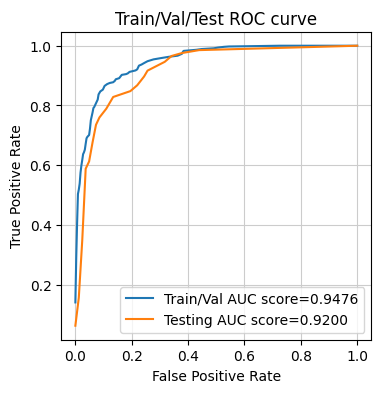

In [61]:
# Compute false positive rate, true positive rate for training and validation predictions
train_val_pred = rf_tuned.predict_proba(X_train_val)[:,1]
test_pred = rf_tuned.predict_proba(X_test)[:,1]

fpr_train_val, tpr_train_val, _ = roc_curve(y_train_val, train_val_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, test_pred)

# AUC scoring on training and validation dataset
AUC_train_val = roc_auc_score(y_train_val, train_val_pred)
AUC_test = roc_auc_score(y_test, test_pred)

plt.figure(figsize=(4,4))
sns.lineplot(x=fpr_train_val, y=tpr_train_val, label=f"Train/Val AUC score={AUC_train_val:.4f}", errorbar=None)
sns.lineplot(x=fpr_test, y=tpr_test, label=f"Testing AUC score={AUC_test:.4f}", errorbar=None)
plt.title(f"Train/Val/Test ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(linestyle='-', color='0.8')
plt.show()

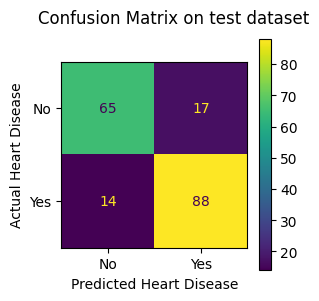

In [62]:
# confusion matrix on test dataset
fig, ax = plt.subplots(figsize=(3,3))
fig.suptitle(f"Confusion Matrix on test dataset")
cmd = ConfusionMatrixDisplay.from_estimator(
    rf_tuned, X_test, y_test, display_labels=['No', 'Yes'], ax=ax)
cmd.ax_.set_xlabel("Predicted Heart Disease")
cmd.ax_.set_ylabel("Actual Heart Disease")
plt.show()

In [63]:
val_predictions = rf_tuned.predict(X_val)

accuracy = accuracy_score(y_val, val_predictions) * 100
precision = precision_score(y_val, val_predictions) * 100
recall = recall_score(y_val, val_predictions) * 100
f1 = f1_score(y_val, val_predictions) * 100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")



Accuracy: 87.50%
Precision: 87.62%
Recall: 90.20%
F1 Score: 88.89%


Regardless of just using training or training + validation data to fit the final model, this model generally performs really well as the false negatives numbers were low, and there isn't overfitting issues as observed in the small difference between training and test AUC scores.

##### 7. Save the model

In [65]:
# Create directory if it does not exist
os.makedirs("../models", exist_ok=True)

joblib.dump(rf_tuned, "../models/heart_disease_model.pkl")

['../models/heart_disease_model.pkl']